**Created: 30.03.2023**

Calculate the cross section for a scattering problem that also has an analytical solution.

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
import subprocess
from scipy.interpolate import interp1d
from scipy.special import riccati_jn, riccati_yn, spherical_jn, spherical_yn, hankel1, hankel2

from scattering import numerov_asymptotic, log_deriv_1ch, log_deriv, S_from_log_deriv

In [2]:
au_to_K = 3.157746662555312504e5

In [3]:
r, dr = np.linspace(0, 20, 5001, retstep=True)

mass = 1
V0 = 1
r_stop = 2
V = -V0 * np.heaviside(r_stop - r, 1)
Vmat = V.reshape((r.size, 1, 1))
Vmat2 = np.zeros((r.size, 2, 2))
Vmat2[:, 0,0] = V
Vmat2[:, 1,1] = V

E = 5

def S0(E):
    K0 = np.sqrt(2*mass*(E+V0))
    k0 = np.sqrt(2*mass*E)
    delta_0 = -k0 * r_stop + np.arctan(k0/K0*np.tan(K0*r_stop))
    return np.exp(2j*delta_0)

def sigma0(E):
    k0 = np.sqrt(2*mass*E)
    return np.pi * np.abs(1 - S0(E))**2 / k0**2

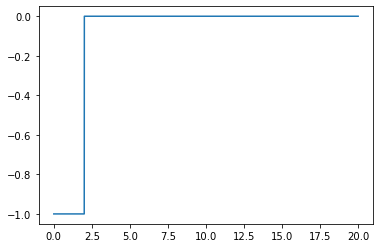

In [4]:
plt.plot(r, V)

# Single energy

## Compare numerov and log-deriv implementation

In [5]:
log_deriv_1ch(E, mass, V, r)

2.1466246432979177

In [6]:
log_deriv(E, mass, Vmat, r)

array([[2.14662464]])

In [7]:
numerov_asymptotic(E, mass, Vmat, r)

array([[2.14598831]])

In [8]:
numerov_asymptotic(E, mass, Vmat2, r)

array([[2.14598831, 0.        ],
       [0.        , 2.14598831]])

##  Compare numerical with analytical result

In [9]:
Y_N = numerov_asymptotic(E, mass, Vmat, r)
S_num = S_from_log_deriv(Y_N, E, [0], mass, Vmat, r)
S_num

array([[0.41120172+0.91154437j]])

In [10]:
Y_N = log_deriv(E, mass, Vmat, r)
S_log = S_from_log_deriv(Y_N, E, [0], mass, Vmat, r, shift=1)
S_log

array([[0.43437632+0.90073149j]])

In [11]:
S0(E)

(0.4348633846437862+0.9004964390246918j)

# Loop over energies

In [12]:
r, dr = np.linspace(0.001, 50, 2001, retstep=True)

mass = 1
V0 = 2
V0_hard = 2000
r_stop = 2
V = -V0 * np.heaviside(r_stop - r, 1)
V_hard = -V0_hard * np.heaviside(r_stop - r, 1)
Vmat = V.reshape((r.size, 1, 1))
Vmat2 = np.zeros((r.size, 2, 2))
Vmat2[:, 0,0] = V
Vmat2[:, 1,1] = V

E = 5

def S0(E):
    K0 = np.sqrt(2*mass*(E+V0))
    k0 = np.sqrt(2*mass*E)
    # Other source: seems to be equivalent to atkins
    delta_0 = np.arctan(
        (k0*np.sin(K0*r_stop)*np.cos(k0*r_stop) - K0*np.sin(k0*r_stop)*np.cos(K0*r_stop)) /
        (K0*np.cos(K0*r_stop)*np.cos(k0*r_stop) + k0*np.sin(k0*r_stop)*np.sin(K0*r_stop))
    )
    # Atkins:
    delta_0 = -k0 * r_stop + np.arctan(k0/K0*np.tan(K0*r_stop))
    return np.exp(2j*delta_0)

def sigma0(E):
    k0 = np.sqrt(2*mass*E)
    return np.pi * np.abs(1 - S0(E))**2 / k0**2

def S1_hard(E):
    # Atkins:
    delta_1 = np.zeros(len(E))
    for iE in range(len(E)):
        k = np.sqrt(2*mass*E[iE])
        delta_1[iE] = np.arctan(-riccati_jn(1, k*r_stop)[0][1] / riccati_yn(1, k*r_stop)[0][1])
    return np.exp(2j*delta_1)

def sigma0_hard(E):
    k = np.sqrt(2*mass*E)
    return 4*np.pi*np.sin(k*r_stop)**2 / k**2

def sigma1_hard(E):
    k = np.sqrt(2*mass*E)
    return np.pi * 3 * np.abs(1 - S1_hard(E))**2 / k**2

In [13]:
def run(method, energies, l_vals, V, r):
    sigma_ch = np.zeros((len(l_vals), energies.size))
    for iE, E in enumerate(energies):
        if method == 'numerov':
            Y_N = numerov_asymptotic(E, mass, V, r)
            shift = 0
        elif method == 'logderiv':
            Y_N = log_deriv(E, mass, V, r)
            shift = 1
        else:
            raise ValueError('Invalid method')
        S = S_from_log_deriv(Y_N, E, l_vals, mass, V, r, shift=shift)
        for ch in range(len(l_vals)):
            k_ch = np.sqrt(2*mass*np.abs(E - V[-1, ch, ch]))
            sigma_ch[ch, iE] = np.pi * np.abs(1 - S[ch, ch])**2 / k_ch**2 * (2*l_vals[ch]+1)
    sigma = sigma_ch.sum(axis=0)
    return sigma, sigma_ch

### l = 0

In [71]:
energies = np.linspace(1, 25, 45)
sigma_num, sigma_ch_num = run('numerov', energies, [0], Vmat, r)

In [72]:
sigma_log, sigma_ch_log = run('logderiv', energies, [0], Vmat, r)

In [73]:
sigma_ana = sigma0(energies)

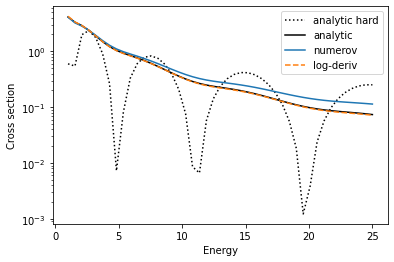

In [74]:
fig, ax = plt.subplots()
ax.plot(energies, sigma0_hard(energies), 'k:', label='analytic hard')
ax.plot(energies, sigma_ana, 'k-', label='analytic')
ax.plot(energies, sigma_num, '-', label='numerov')
ax.plot(energies, sigma_log, '--', label='log-deriv')
ax.set_yscale('log')
ax.set_xlabel('Energy')
ax.set_ylabel('Cross section')
ax.legend()
plt.show()

### l = 1

In [75]:
V_l1 = -V0_hard * np.heaviside(r_stop - r, 1) + 3/(2*mass*r**2)
Vmat_l1 = V_l1.reshape((r.size, 1, 1))

In [76]:
sigma_l1_num, sigma_l1_ch_num = run('numerov', energies, [1], Vmat_l1, r)

In [77]:
sigma_l1_log, sigma_l1_ch_log = run('logderiv', energies, [1], Vmat_l1, r)

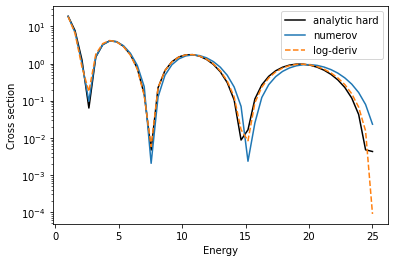

In [78]:
fig, ax = plt.subplots()
ax.plot(energies, sigma1_hard(energies), 'k-', label='analytic hard')
ax.plot(energies, sigma_l1_num, '-', label='numerov')
ax.plot(energies, sigma_l1_log, '--', label='log-deriv')
ax.set_yscale('log')
ax.set_xlabel('Energy')
ax.set_ylabel('Cross section')
ax.legend()
plt.show()